# TrOCR on Historical Text

In [ ]:
!nvidia-smi # to see the details of the GPU being used

Wed Feb 15 23:23:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Google Drive Connection
The Google Colab notebook is connected to my Google drive using gdfuse, to enable access to data stored in the drive. The code has been used from
https://stackoverflow.com/questions/69822304/google-colab-google-drive-can%C2%B4t-be-mounted-anymore-browser-popup-google-dri

In [1]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [2]:
!sudo apt-get install -qq w3m
!xdg-settings set default-web-browser w3m.desktop
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 128213 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


## Setup
Making necessary installations and imports required for the project and configuring the model.

In [3]:
!pip install transformers # installing the Transformers library from HuggingFace
!pip install torch # installing PyTorch framework
!pip install jiwer # installing jiwer for loading CER metric
!pip install evaluate # installing the Evaluate library from HuggingFace to use the CER metric for evaluation
!pip install -q gradio # installing Gradio to create an interactive demo of the model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [4]:
# Importing necessary packages
import pandas as pd # pandas for reading csv files
import matplotlib.pyplot as plt # for creating plots
from copy import deepcopy # to create exact copy of a variable at another memory location
from sklearn.model_selection import train_test_split # for splitting the data into train, validation and test sets
import torch # PyTorch used for executing deep learning functions
# to store the data and ground truths to be used by the model, loader is an iterable over the Datasets created, the last one is to concatenate Dataset objects
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image, ImageTk # to display the image from the encoded pixels
from transformers import TrOCRProcessor, VisionEncoderDecoderModel # importing the TrOCR processor representing the visual feature extrcator and tokenizer of the TrOCR model, and the TrOCR model
import evaluate # for using the CER metric
from tqdm.notebook import tqdm # to display the progress bar, improves UX (referred to https://github.com/tqdm/tqdm#usage)
# import gradio as gr # to create a demo of the model which can be deployed on HuggingFace Spaces
import time # to use in calculating the runtime

In [5]:
!huggingface-cli login # to login to huggingface to import the already fine-tuned model and to push to the model repo created for this finetuned model


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [6]:
# Base code has been referred to from the official website of 
# the trocr-base-handwritten model- https://huggingface.co/microsoft/trocr-base-handwritten

# to create an object of TrOCRProcessor with the given pre-trained model trocr-base-handwritten 
# which wraps ViTFeatureExtractor (to normalize input images) and 
# RobertaTokenizer (to encode and decode text to and from input_ids created) as one entity
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# loading and initializing with the pre-trained base trocr model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# created after training the fine-tuned model after few runs of this code
custom_model = VisionEncoderDecoderModel.from_pretrained("sk2003/hist-trocr") 

# ADAM optimizer with decaying weights and the learning rate is set to 0.00005 which has been found to be most-used for Transformers
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
cer_metric = evaluate.load("cer") # CER metric is loaded from the Evaluate library

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# configuring the base_handwritten model and setting undefined parameters, used initially before the custom_model was made
# the decoder input_ids require the start and pad tokens, they are created by shifting the input to the right once
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id # id (=0) of the class token- <s> used as the first token after the inputs are shifted to the right for the decoder
model.config.pad_token_id = processor.tokenizer.pad_token_id # id (=1) of the pad token- <pad>
model.config.vocab_size = model.config.decoder.vocab_size # language modelling vocabulary size is set to default value of the decoder of the model (=50625)

# sequence generation parameters associated with beam search (https://huggingface.co/blog/how-to-generate)
model.config.eos_token_id = processor.tokenizer.sep_token_id # id (=2) of the separator token- </s> that is used at the end of the string, originally undefined
model.config.max_length = 200 # maximum length to be used by the text generation function, originally 20
# for below value- (https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/#:~:text=Common%20beam%20width%20values%20are,better%20matching%20a%20target%20sequence.)
model.config.num_beams = 5 # number of beams in beam search, beam width - number of sequences to consider while picking the one with the highest probablity, originally 1 (so only greedy search)
model.config.early_stopping = True # beam search is stopped when 5(num_beams) sentences are done at a time (batch), originally False
model.config.no_repeat_ngram_size = 3 # ngrams of size 3 can occur only once, to avoid word repetitions

In [ ]:
print("Model configuration:\n",model.config) # snapshot of all the default and manually configured values

VisionEncoderDecoderConfig {
  "_commit_hash": "0cc7abaad739c7902dabd562356c7e6a7be834ea",
  "_name_or_path": "microsoft/trocr-base-handwritten",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 768,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 12,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": nu

In [8]:
# Displaying details regarding the processor used
print("Image processor used:\n",processor.image_processor) # the visual feature extractor used
print("Input of the image processor: ",processor.image_processor.model_input_names) # input name of the image processor
print("Tokenizer used:\n",processor.tokenizer) # details of the tokenizer
print("Input of the tokenizer:",processor.tokenizer.model_input_names) # input name of the tokenizer

Image processor used:
 ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

Input of the image processor:  ['pixel_values']
Tokenizer used:
 RobertaTokenizerFast(name_or_path='microsoft/trocr-base-handwritten', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=

In [9]:
print("The structure of the model used:\n",model.parameters) # displaying layers used, activation functions, and other details of the model

The structure of the model used:
 <bound method Module.parameters of VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (inter

## Exploratory Data Analysis and Dataframe Preparation
Understanding and cleaning the data to be made useful for processing by the model.

### Washington Database
 Created from George Washington Papers at the Library of Congress, USA

In [10]:
# Reading the ground truth labels associated with the line images from the Washington Database
data_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/washingtondb-v1.0/ground_truth/ground_truths.csv', header=None)
images_location_1 = '/content/drive/MyDrive/Colab Notebooks/washingtondb-v1.0/data/line_and_word_images_normalized/' # path of the image folder
data_1.head() # glimpse of first 5 elements in the dataframe

,0,1
0,270-01,s_2-s_7-s_0-s_pt|L-e-t-t-e-r-s-s_cm|O-r-d-e-r-...
1,270-03,o-n-l-y|f-o-r|t-h-e|p-u-b-l-i-c-k|u-s-e-s_cm|u...
2,270-04,l-a-r|O-r-d-e-r-s|f-r-o-m|m-e-s_pt|Y-o-u|a-r-e...
3,270-05,d-o-w-n|a|B-a-r-r-e-l|o-f|F-l-i-n-t-s|w-i-t-h|...
4,270-06,W-i-n-c-h-e-s-t-e-r-s_cm|a-n-d|a-b-o-u-t|t-w-o...


In [11]:
data_1.info() # to examine the types of the data in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       756 non-null    object
 1   1       756 non-null    object
dtypes: object(2)
memory usage: 11.9+ KB


In [12]:
# Changing the names of the columns in the same dataframe for easy referrence to the columns
data_1.rename(columns={0: "file_name", 1: "text"}, inplace=True)
data_1.columns # to see the column/attribute names

Index(['file_name', 'text'], dtype='object')

In [13]:
# adding 'png' to the end of the file names read from the csv 
# so as the contents of the column contain the file names with the extension to refer to the images
# as all images are png files
data_1['file_name'] = [x + ".png" for x in data_1['file_name']]
print(data_1['file_name'])

0         270-01.png
1         270-03.png
2         270-04.png
3         270-05.png
4         270-06.png
           ...      
751    270-18-03.png
752    270-18-04.png
753    270-18-05.png
754    270-18-06.png
755    270-19-01.png
Name: file_name, Length: 756, dtype: object


In [14]:
# to get the special characters which are prefixed by 's_' (special charcaters)
specials = deepcopy(data_1) # making a copy of the data_1 dataframe so that steps in this cell do not affect the original dataframe
specials['text'] = specials['text'].str.replace('|','-') # all | used to represent spaces are replaced with -
specials = specials[specials['text'].str.contains('s_')]['text'].str.split('-') # the strings are split by - to extract records with '_s'
s_chars = [] # for storing the list of 'special' characters detected
# iterating over the contents of the specials individually to extract only the special characters into s_chars list
for lists in specials:
  for chars in lists:
    if 's_' in chars:
      s_chars.append(chars)
# keeping only the unique elements from s_chars by making it a set 
# but it is converted back to a list as they are subscriptable so
# would enable access to elements as specefied indices
s_chars = list(set(s_chars)) 
print("Special characters:\n",s_chars)

Special characters:
 ['s_9th', 's_bl', 's_6', 's_lb', 's_qo', 's_5th', 's_0', 's_1st', 's_8th', 's_1', 's_2', 's_3', 's_mi', 's_7th', 's_5', 's_8', 's_sl', 's_s', 's_4', 's_pt', 's_1th', 's_7', 's_2nd', 's_et', 's_0th', 's_3rd', 's_cm', 's_GW', 's_br', 's_qt', 's_sq', 's_9', 's_6th']


<ipython-input-14-e19469728897>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  specials['text'] = specials['text'].str.replace('|','-') # all | used to represent spaces are replaced with -


In [15]:
# all words in the ground truth have been separated by bars (|) so they are converted back to spaces
data_1['text'] = data_1['text'].str.replace('|',' ')
# all characters in the ground truth have been separated by hyphens (-) so they are removed
data_1['text'] = data_1['text'].str.replace('-','')
data_1['text'].head # to check out the text column after the hyphens are removed

<ipython-input-15-53684f5380c7>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_1['text'] = data_1['text'].str.replace('|',' ')


<bound method NDFrame.head of 0      s_2s_7s_0s_pt Letterss_cm Orders and Instructi...
1      only for the publick uses_cm unles_ss by parti...
2                 lar Orders from mes_pt You are to send
3           down a Barrel of Flints with the Armss_cm to
4           Winchesters_cm and about two thousand weight
                             ...                        
751                                          immediately
752                                                   to
753                                                   go
754                                           Recruis_mi
755                                             tings_sq
Name: text, Length: 756, dtype: object>

s_9th -->  s_2s_9ths_pt To Lieutenant Colonel Adam Stephens_cm


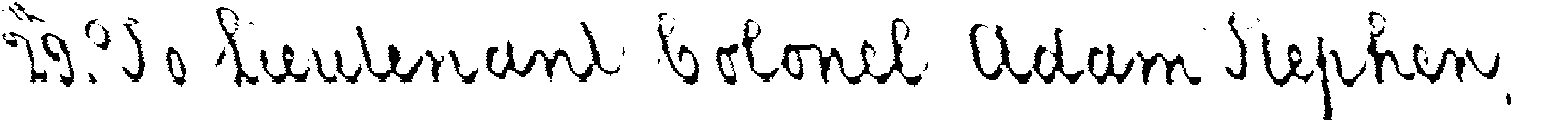




s_bl -->  yourself s_blor at least ought to bes_br that your Crime


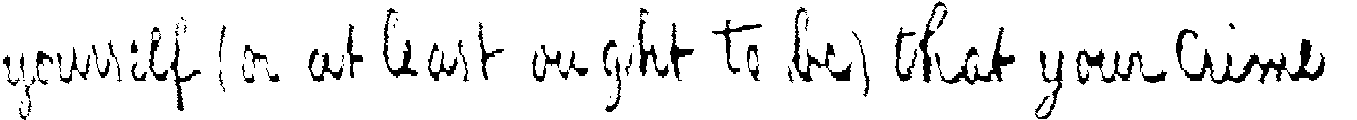




s_6 -->  October s_2s_6ths_pt s_GW


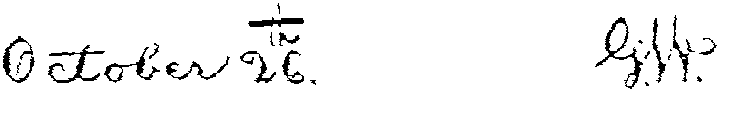




s_lb -->  s_lbs_1s_0s_0s_0 which I wrote for to pay off the Troopss_cm


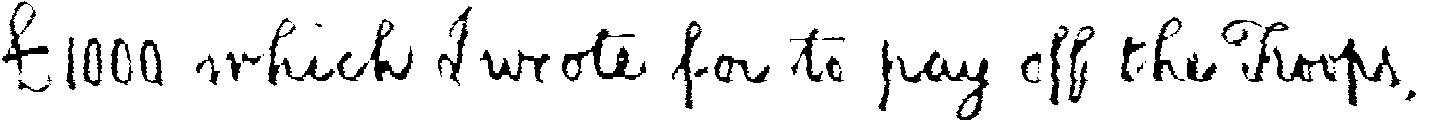




s_qo -->  s_2s_8th Winchesters_qo October s_2s_8ths_cm s_1s_7s_5s_5s_pt


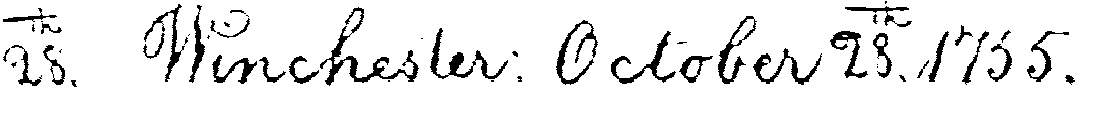




s_5th -->  s_5ths_pt To the Honourable Robert Dinwiddies_cm


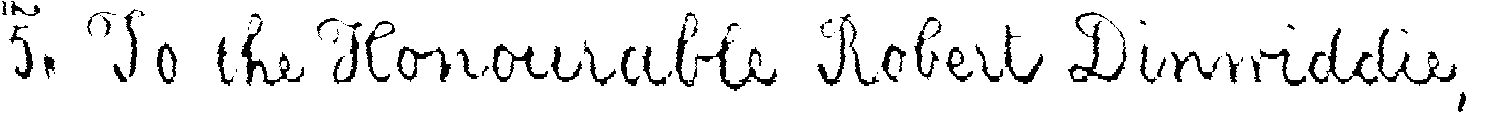




s_0 -->  s_2s_7s_0s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


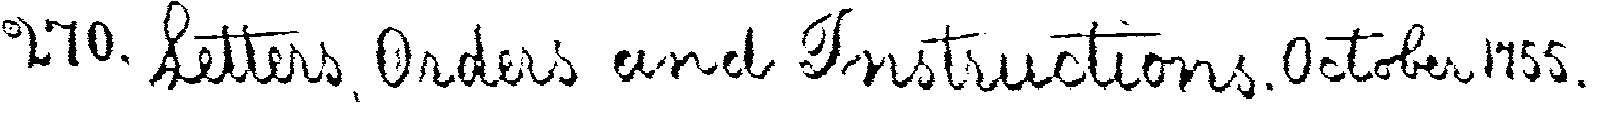




s_1st -->  tings_sq and they are allowed until the s_1sts_pt of Des_mi


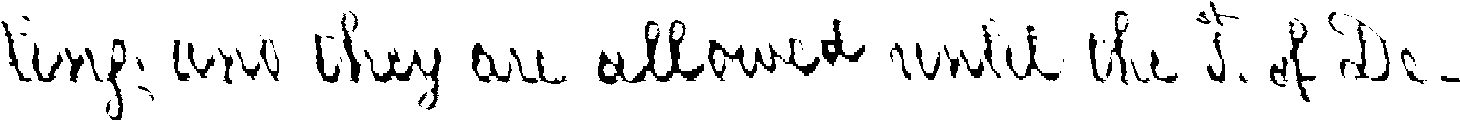




s_8th -->  s_2s_8th Winchesters_qo October s_2s_8ths_cm s_1s_7s_5s_5s_pt


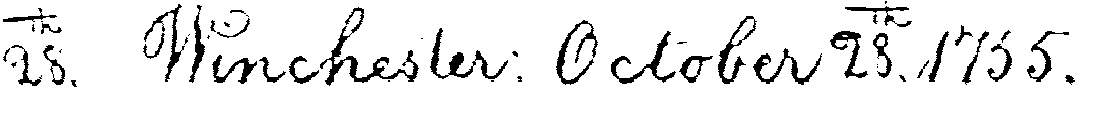




s_1 -->  s_2s_7s_0s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


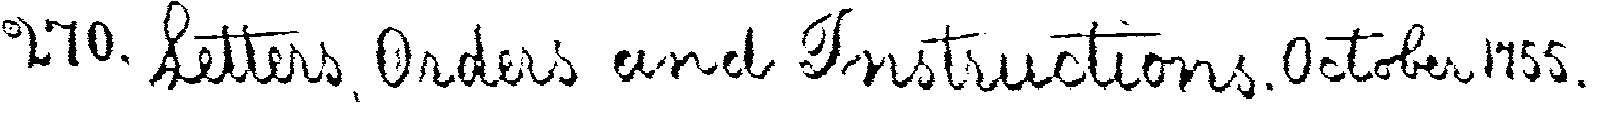




s_2 -->  s_2s_7s_0s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


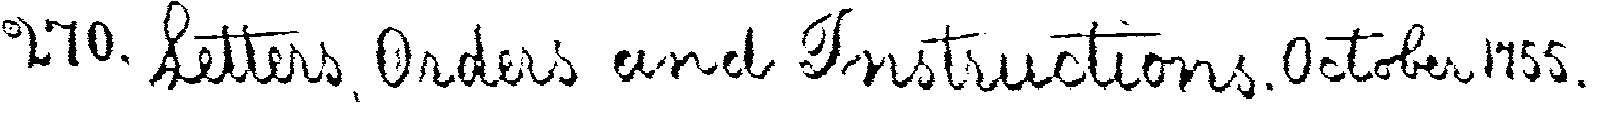




s_3 -->  Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt s_2s_7s_3s_pt


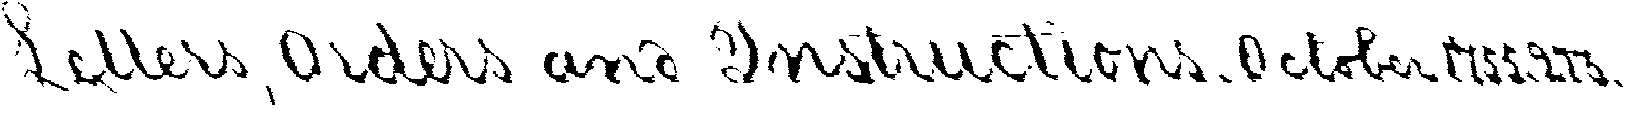




s_mi -->  only for the publick uses_cm unles_ss by particus_mi


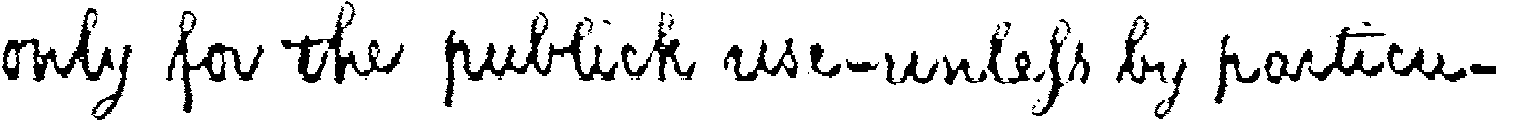




s_7th -->  he was appointed the s_1s_7ths_pt of Septembers_pt


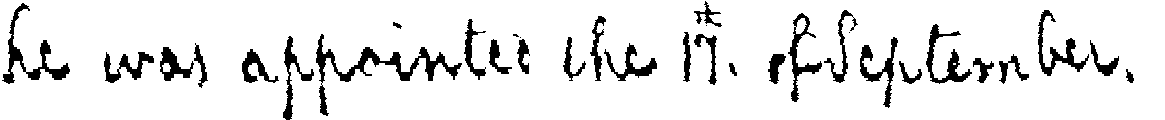




s_5 -->  s_2s_7s_0s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


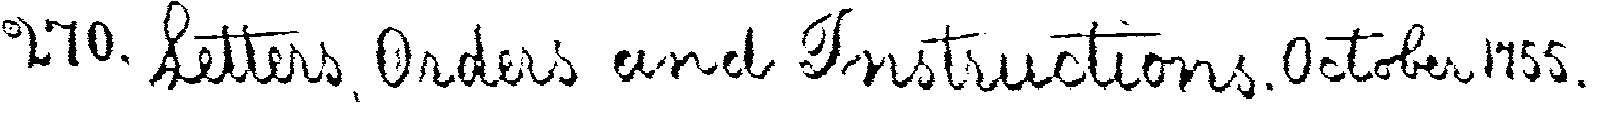




s_8 -->  s_2s_8th Winchesters_qo October s_2s_8ths_cm s_1s_7s_5s_5s_pt


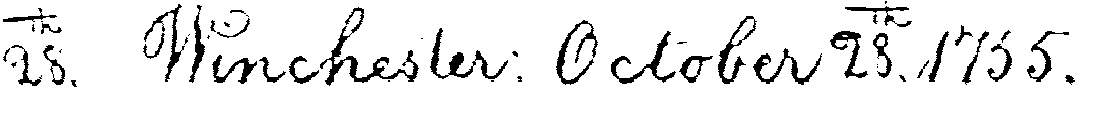




s_sl -->  has been at s_2s_ss_sls_pt per bushels_pt You may procure


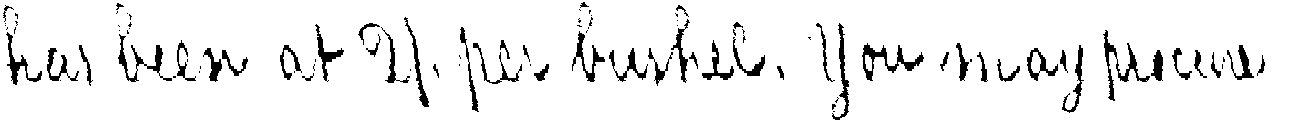




s_s -->  only for the publick uses_cm unles_ss by particus_mi


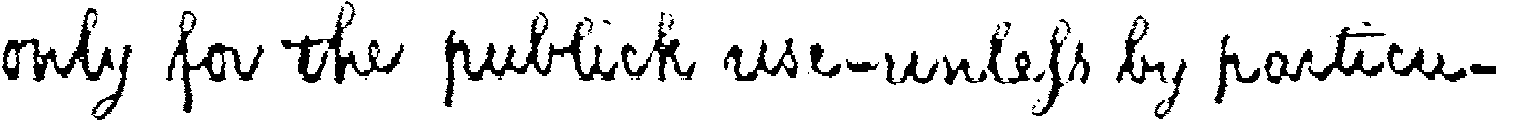




s_4 -->  s_2s_7s_4s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


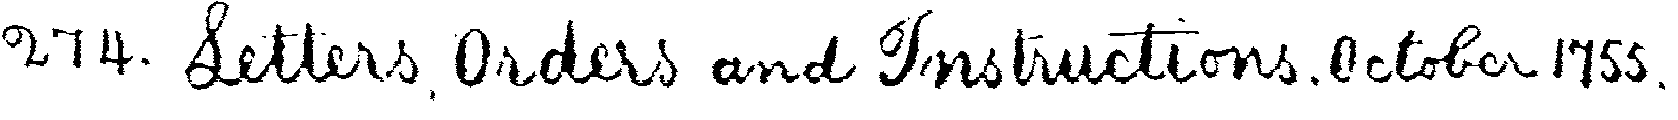




s_pt -->  s_2s_7s_0s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


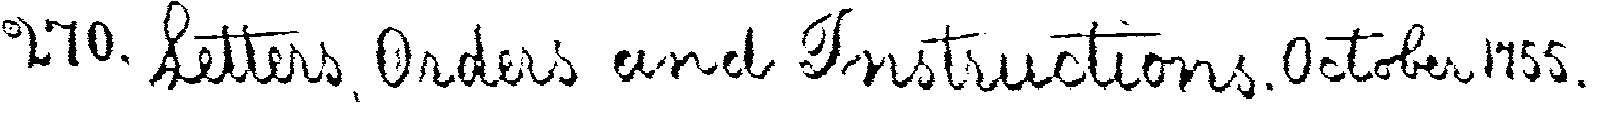




s_1th -->  s_1s_1ths_pt To Sergeant Campbells_cm of the Virginia Regiments_pt


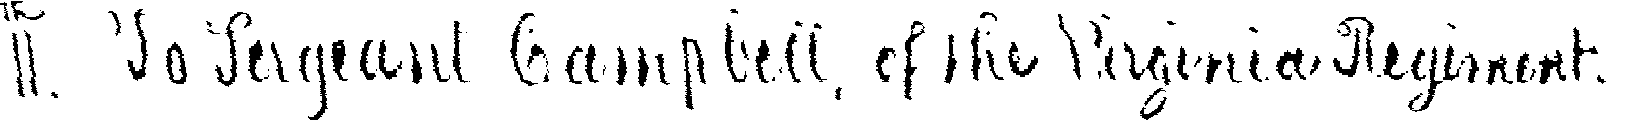




s_7 -->  s_2s_7s_0s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


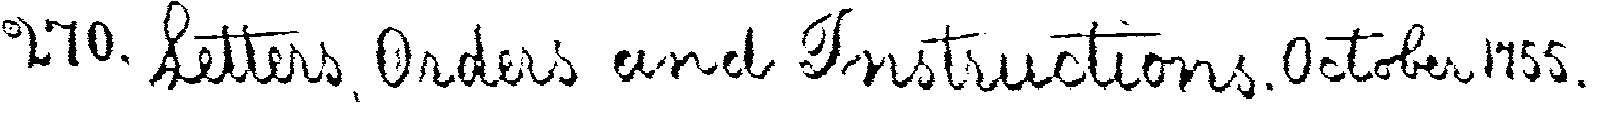




s_2nd -->  s_2s_2nds_pt Parole Bostons_mi Winchesters_qo December s_2s_2nds_pt s_1s_7s_5s_5s_pt


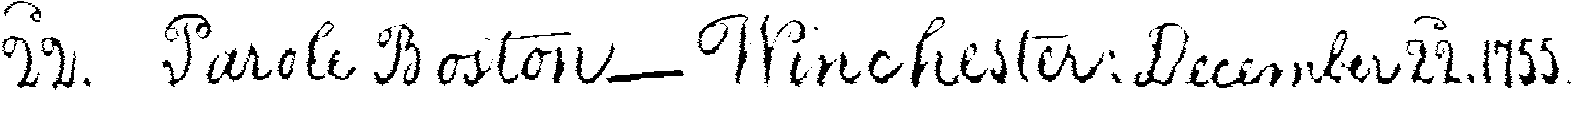




s_et -->  to provide mediciness_cm s_etcs_pt upon the best terms


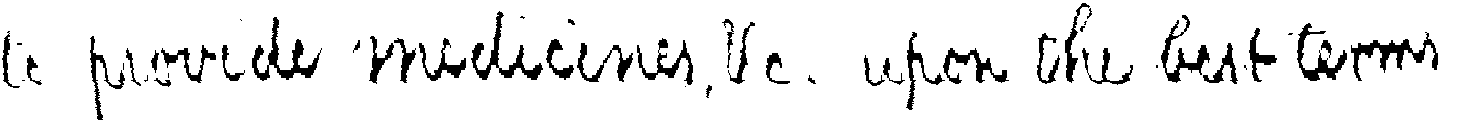




s_0th -->  Octos_pt s_3s_0ths_pt To Sergeant David Wilpers_cm of the Virginia


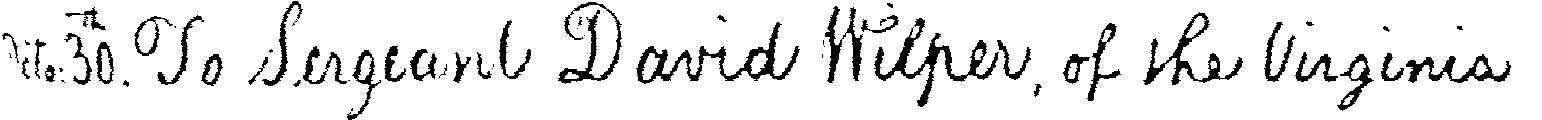




s_3rd -->  ther officers on the s_3rds_pt instant s_etcs_pt


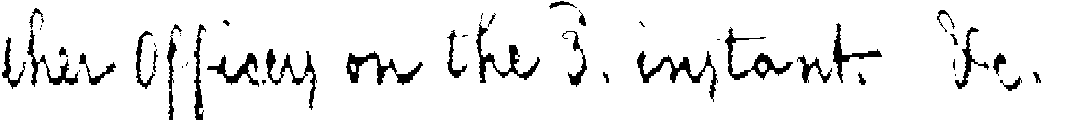




s_cm -->  s_2s_7s_0s_pt Letterss_cm Orders and Instructionss_pt October s_1s_7s_5s_5s_pt


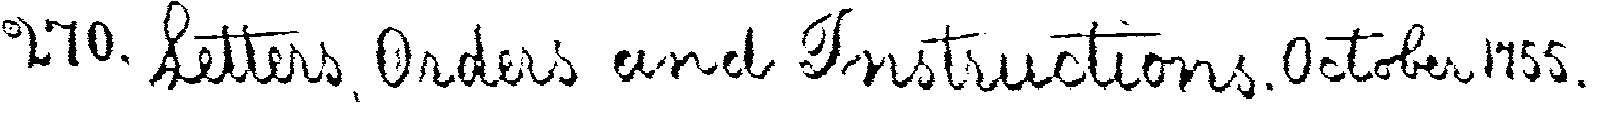




s_GW -->  October s_2s_6ths_pt s_GW


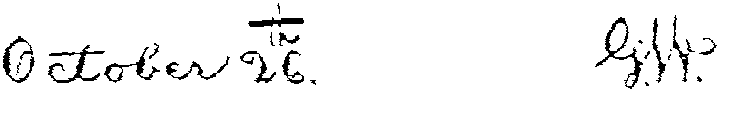




s_br -->  yourself s_blor at least ought to bes_br that your Crime


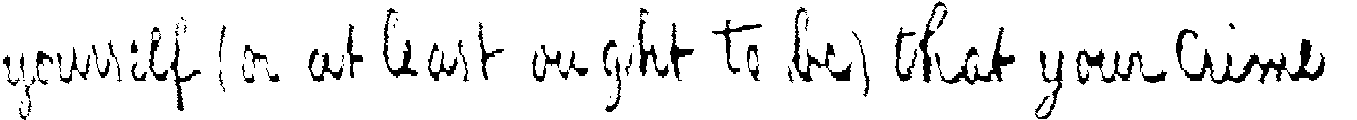




s_qt -->  Cockess_qt Companys_cm at Nicholas Reasmerss_pt


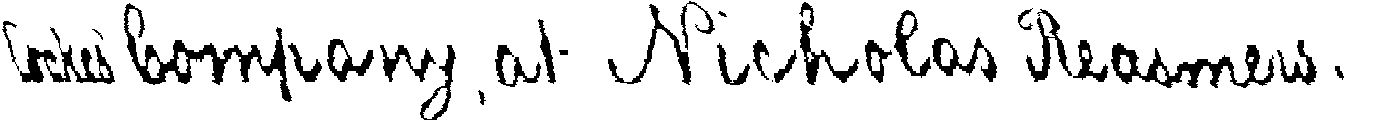




s_sq -->  of Flours_cm for the two Companies of Rangerss_sq


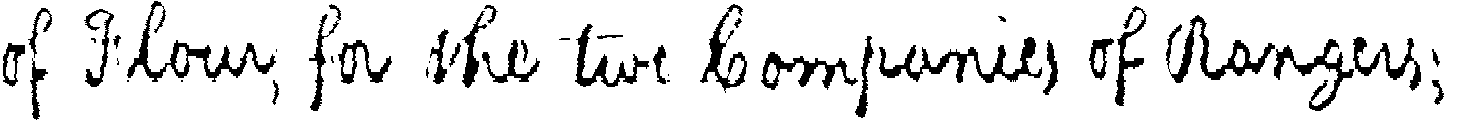




s_9 -->  s_2s_9ths_pt To Lieutenant Colonel Adam Stephens_cm


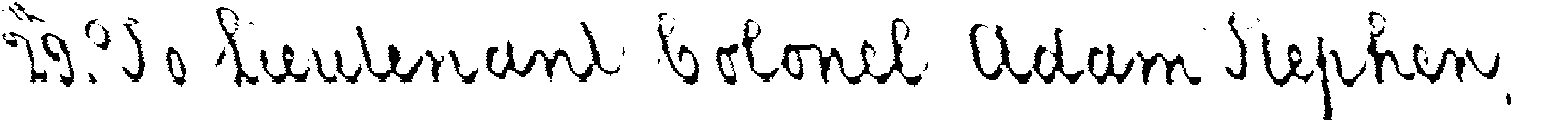




s_6th -->  October s_2s_6ths_pt s_GW


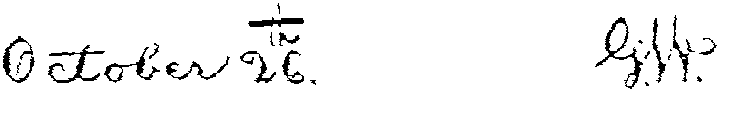

In [16]:
# for visualizing charcaters prefixed by 's_' to understand the actual character they represent
for special in s_chars:
  df = data_1[data_1['text'].str.contains(special)] # extract instances where the text contains the special set of characters
  df.reset_index(drop=True, inplace=True) # reset the indices to start from 0 for easy reference to the instances
  print(special,"--> ",df['text'][0]) # displaying the text associated with the instance
  image = Image.open(images_location_1 + df['file_name'][0]) # Image object associated with the image of instance is created
  display(image) # displaying the image associated with the instance
  print("\n\n")
  

In [17]:
# Records with s_sl character are removed as they could not be properly identified 
# As it is only 1 record, not much of a difference will be made
data_1.drop(data_1.index[data_1['text'].str.contains('s_sl')], inplace = True)
data_1.reset_index(drop=True, inplace=True) # resetting the indices of the dataframe after the record is removed
s_chars.remove('s_sl') # this special character is removed from the list of special characters as well

In [19]:
# the ground truth labels from the csv contain special tokens for some characters
# which are being replaced with their actual versions 
replace_chars = {'s_pt':'.', 's_qo':':','s_mi':'-', 's_bl':'(', 's_br':')', 's_sq':';', 's_s':'s', 's_cm':',', 's_qt':"'", 's_et':'et', 's_lb':'£', 's_GW':'G.W.', 's_0':'0', 's_1':'1', 's_2':'2', 's_3':'3', 's_4':'4', 's_5':'5', 's_6':'6', 's_7':'7', 's_8':'8', 's_9':'9' }
# iterating over the dictionary to replace the keys' values in the records with the values from the dictionary
for char in replace_chars.keys():
  data_1['text'] = data_1['text'].str.replace(char, replace_chars[char])

data_1.head() # glimpse of the dataframe

,file_name,text
0,270-01.png,"270. Letters, Orders and Instructions. October..."
1,270-03.png,"only for the publick use, unless by particu-"
2,270-04.png,lar Orders from me. You are to send
3,270-05.png,"down a Barrel of Flints with the Arms, to"
4,270-06.png,"Winchester, and about two thousand weight"


In [20]:
print("Dimensions of the dataframe (rows, columns):", data_1.shape) # dimensions of the dataframe- (4894 rows, 2 columns)

Dimensions of the dataframe (rows, columns): (755, 2)


In [21]:
data_1.isnull().sum() # confirming the dataframe does not contain any NULL values

file_name    0
text         0
dtype: int64

In [22]:
data_1[data_1['text'] == ''].index # confirming the dataframe does not contain any empty values

Int64Index([], dtype='int64')

In [23]:
# to check for duplicate entries
data_1[data_1.duplicated()] # or set(data.duplicated()) gives only False

,file_name,text


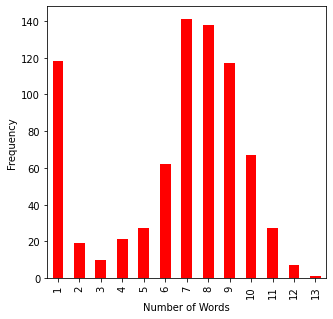

In [24]:
# plotting the images with a given number of words versus the frequnecy of those type of images in the data
# for example, around 120 images contain text with only 1 word
plt.figure(figsize=(5,5)) # size of the figure to be displayed
# the text column's value in the record is split by spaces to get the number of words
# value_counts sorts by value automatically, sort_index() to sort in ascending by value
data_1.text.str.split(" ").str.len().value_counts().sort_index().plot(kind='bar', color='red')
plt.ylabel("Frequency") # x axis' label - number of images
plt.xlabel("Number of Words") # y axis' label - number of words in the images
plt.show() # display the graph

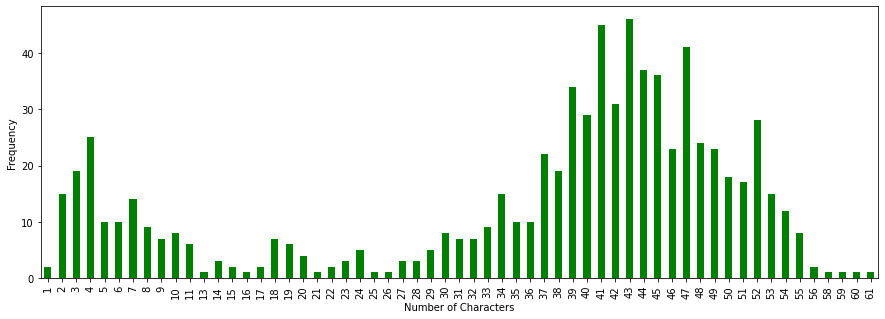

In [25]:
# plotting the images with a given number of characters versus the frequnecy of those type of images in the data
plt.figure(figsize=(15,5)) # size of the figure to be displayed
# getting the length of the record in characters (including spaces)
# value_counts sorts by value automatically, sort_index() to sort in ascending by value
data_1.text.str.len().value_counts().sort_index().plot(kind='bar',color='green')
plt.ylabel("Frequency") # x axis' label - number of images
plt.xlabel("Number of Characters") # y axis' label - number of characters in the images
plt.show() # display the graph

In [26]:
# to get the text transcription of the maximum length in the text column
print("The longest string is of", data_1.text.str.len().max(), "characters.")
print("The longest string is of", (data_1.text.str.split(" ")).str.len().max(), "words.")

The longest string is of 61 characters.
The longest string is of 13 words.


#### Visualization
Visualizing sample images and their proper English transcriptions from the dataset.

Ground truth label: October 26th. G.W.


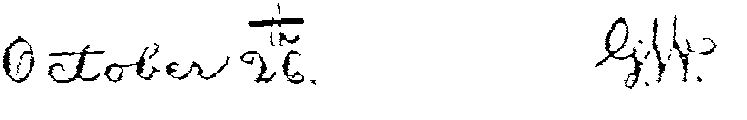

In [36]:
print("Ground truth label:", data_1['text'][10]) # displaying the ground truth from the text column
Image.open(images_location_1 + data_1['file_name'][10]).convert("RGB") # display the PIL image

Ground truth label: Sir,


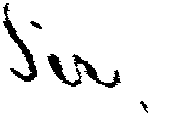

In [37]:
print("Ground truth label:", data_1['text'][67])
Image.open(images_location_1 + data_1['file_name'][67]).convert("RGB")

Ground truth label: make provisions for you. If any of your men


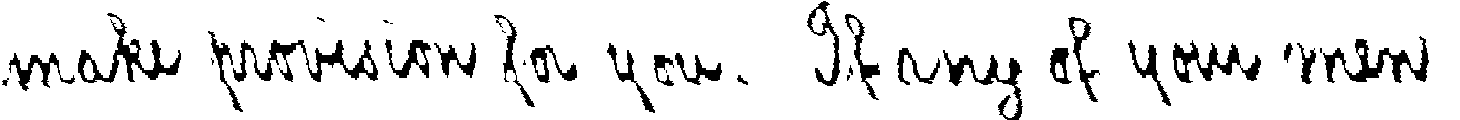

In [38]:
print("Ground truth label:", data_1['text'][100])
Image.open(images_location_1 + data_1['file_name'][100]).convert("RGB")

Ground truth label: rival of the Vessel with arms, etc. from James


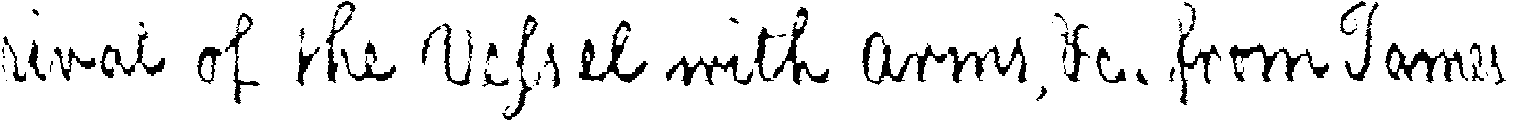

In [39]:
print("Ground truth label:", data_1['text'][350])
Image.open(images_location_1 + data_1['file_name'][350]).convert("RGB")

Ground truth label: A Return is to be made every mor-


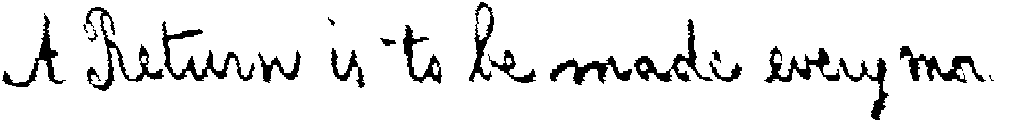

In [40]:
print("Ground truth label:", data_1['text'][645])
Image.open(images_location_1 + data_1['file_name'][645]).convert("RGB")

### ARDIS Dataset
Created from 15000 Swedish church records from the 19th and 20th centuries

In [29]:
# reading the excel sheet with the file names and the ground truth in the 'Date' column
data_2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dates/Part I.xlsx')
images_location_2 = '/content/drive/MyDrive/Colab Notebooks/Dates/Part I/' # location of the folder with the images
data_2.head() # to have a glmipse of the first 5 instances in the dataframe

,Image_Left,Image_Right,City,Date,Category
0,v120849.b1210.s114,NaN,Alnö,1900,Födda
1,v120849.b1600.s153,NaN,Alnö,1901,Födda
2,v120849.b1990.s192,T_v120849.b1990.s192,Alnö,1902,Födda
3,v120849.b2340.s227,T_v120849.b2340.s227,Alnö,1903,Födda
4,v120849.b2690.s262,T_v120849.b2690.s262,Alnö,1904,Födda


In [30]:
# removing the 'Image_Right', 'City', and 'Category' columns as they are not required for our analysis*
data_2.drop(['Image_Right', 'City', 'Category'], axis = 1, inplace = True) 
data_2.head() # viewing the data after dropping the columns

,Image_Left,Date
0,v120849.b1210.s114,1900
1,v120849.b1600.s153,1901
2,v120849.b1990.s192,1902
3,v120849.b2340.s227,1903
4,v120849.b2690.s262,1904


In [31]:
data_2.info() # to examine the types of the data in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Left  2548 non-null   object
 1   Date        2548 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.9+ KB


In [32]:
# Changing the names of the columns in the same dataframe for easy referrence to the columns
data_2.rename(columns={"Image_Left": "file_name", "Date": "text"}, inplace=True)
data_2.columns # to see the column/attribute names

Index(['file_name', 'text'], dtype='object')

In [33]:
# Changing the data type of the 'text' column
data_2 = data_2.astype({'text': 'str'})
print(data_2.dtypes)

file_name    object
text         object
dtype: object


In [34]:
# adding 'jpg' to the end of the file names read from the excel sheet 
# so as the contents of the column contain the file names with the extension to refer to the images
# as all images are jpg files
data_2['file_name'] = [x + ".jpg" for x in data_2['file_name']]
print(data_2['file_name'])

0       v120849.b1210.s114.jpg
1       v120849.b1600.s153.jpg
2       v120849.b1990.s192.jpg
3       v120849.b2340.s227.jpg
4       v120849.b2690.s262.jpg
                 ...          
2543      v214662.b680.s64.jpg
2544      v214662.b740.s70.jpg
2545      v214662.b800.s76.jpg
2546      v214662.b930.s89.jpg
2547      v214662.b980.s94.jpg
Name: file_name, Length: 2548, dtype: object


In [41]:
print("Dimensions of the data_2 (rows, columns):",data_2.shape) # dimensions of the dataframe- (4894 rows, 2 columns)

Dimensions of the data_2 (rows, columns): (2548, 2)


In [42]:
data_2.isnull().sum() # confirming the dataframe does not contain any NULL values

file_name    0
text         0
dtype: int64

In [43]:
data_2[data_2['text'] == ''].index # confirming the dataframe does not contain any empty values

Int64Index([], dtype='int64')

In [44]:
# to check for duplicate entries
data_2[data_2.duplicated()] # or set(data.duplicated()) gives only False

,file_name,text


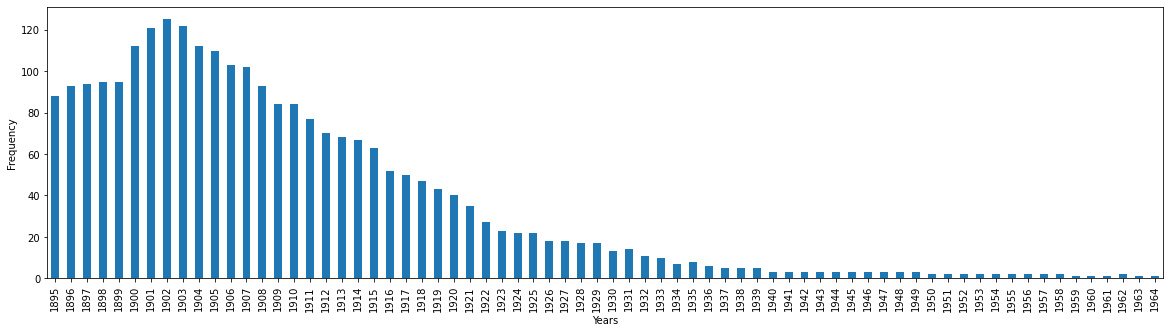

In [45]:
# displaying all the years in the text and their frequency of appearance in the images
plt.figure(figsize=(20,5)) # size of the figure (width, height)
data_2['text'].value_counts().sort_index().plot(kind='bar') # displaying a bar chart with the years sorted in ascending order
plt.ylabel("Frequency") # x axis' label- frequency of occurence of the years
plt.xlabel('Years') # y axis' label- the years in the images
plt.show() # to display the graph

#### Visualization
Visualizing sample images and their transcriptions from the dataset.

Ground truth label: 1901


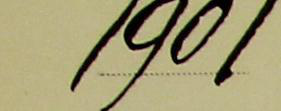

In [46]:
print("Ground truth label:", data_2['text'][1]) # displaying the ground truth label of the image which would be displayed
Image.open(images_location_2 + data_2['file_name'][1]).convert("RGB") # displaying the PIL image

Ground truth label: 1898


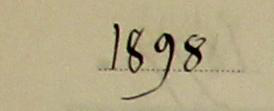

In [47]:
print("Ground truth label:", data_2['text'][80])
Image.open(images_location_2 + data_2['file_name'][80]).convert("RGB")

Ground truth label: 1906


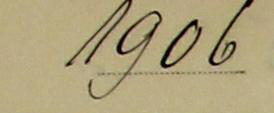

In [48]:
print("Ground truth label:", data_2['text'][500])
Image.open(images_location_2 + data_2['file_name'][500]).convert("RGB")

Ground truth label: 1917


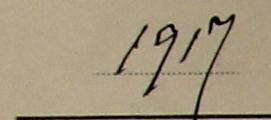

In [49]:
print("Ground truth label:", data_2['text'][2100])
Image.open(images_location_2 + data_2['file_name'][2100]).convert("RGB")

## Dataset Preparation
Creating Datasets for training, validation and testing.

In [50]:
train_1, test_1 = train_test_split(data_1, test_size=0.2) # splitting the data_1 dataframe into train and test sets with 80-20 split
train_1, val_1 = train_test_split(train_1, test_size=0.25) # further splitting the training set using 75-25 split for the validation set

# the indices of the three data sets are reset in the same dataframe to freshly start from 0 each
# instead of retaining indices from the original 'data' dataframe and the old indices are avoided being put as another column
train_1.reset_index(drop=True, inplace=True)
val_1.reset_index(drop=True, inplace=True)
test_1.reset_index(drop=True, inplace=True)

In [51]:
train_2, test_2 = train_test_split(data_2, test_size=0.2) # splitting the data_2 dataframe into train and test datasets
train_2, val_2 = train_test_split(train_2, test_size=0.25) # further splitting for the validatio set

# the indices of the three data sets are reset to 0 and old indices are avoided being put as another column
train_2.reset_index(drop=True, inplace=True)
val_2.reset_index(drop=True, inplace=True)
test_2.reset_index(drop=True, inplace=True)

In [52]:
class ImageData(Dataset):
    """
    Class representing a custom PyTorch Dataset implementation with the images and their labels
    """
    def __init__(self, data, location, processor):
        """
        Initialization Function 
        """
        self.data = data # the dataframe
        self.location = location # location of the images (path of the folder)
        self.processor = processor # TrOCR processor to use

    def __len__(self):
        """
        Function to get the number of samples in the Dataset
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Function/Getter for the contents of a ImageData object at index- idx
        Parameter:
        idx - index at which the contents are to be retrieved
        """
        # to get the image file's name
        img_file = self.location + self.data['file_name'][idx]
        # resizing and normalizing the image to (3, 384, 384) (=(channels, image width and height)) after removing the unnecessary 1 dimension by using squeeze()
        pixels = (self.processor(Image.open(img_file).convert("RGB"), return_tensors="pt").pixel_values).squeeze()
        # encoding the text and getting the input ids or the encoded ground truth values 
        # and all values until after the last value- 200th one, will be made the padding token
        enc_values = self.processor.tokenizer(self.data['text'][idx], 
                                          padding="max_length", 
                                          max_length=200).input_ids

        # encoded ground truth values are made into a tensor to use in computation 
        # while the pad tokens each are set to -100 to be ignored during the computation of the loss
        enc_values = torch.tensor([value if value != self.processor.tokenizer.pad_token_id else -100 for value in enc_values])

        encodings = {"pixel_values": pixels, "labels": enc_values} # the keys are named because the forward pass expects these keys
        return encodings

In [53]:
# Creating ImageData objects for training, validation and testing sets

# ImageData objects from split data_1
train_df_1 = ImageData(data=train_1, location=images_location_1, processor=processor)
val_df_1 = ImageData(data=val_1, location=images_location_1, processor=processor)
test_df_1 = ImageData(data=test_1, location=images_location_1, processor=processor)

# ImageData objects from split data_2
train_df_2 = ImageData(data=train_2, location=images_location_2, processor=processor)
val_df_2 = ImageData(data=val_2, location=images_location_2, processor=processor)
test_df_2 = ImageData(data=test_2, location=images_location_2, processor=processor)

# Concatenating the ImageData objects created with the two split dataframes
train_df = ConcatDataset([train_df_1,train_df_2])
val_df = ConcatDataset([val_df_1,val_df_2])
test_df = ConcatDataset([test_df_1, test_df_2])

# Creating DataLoaders for training, validation and testing data sets, each element is a batch of size 32*
# with data samples and all batches are shuffled at every epoch 
train_dataloader = DataLoader(train_df, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_df, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_df, batch_size=16, shuffle=True)

# Creating DataLoaders for training, validation and testing data sets, each element is a batch of size 32
# with data samples and all batches are shuffled at every epoch 
train_dataloader_1 = DataLoader(train_df_1, batch_size=16, shuffle=True)
val_dataloader_1 = DataLoader(val_df_1, batch_size=16, shuffle=True)
test_dataloader_1 = DataLoader(test_df_1, batch_size=16, shuffle=True)
# Creating DataLoaders for training, validation and testing data sets, each element is a batch of size 32
# with data samples and all batches are shuffled at every epoch 
train_dataloader_2 = DataLoader(train_df_2, batch_size=16, shuffle=True)
val_dataloader_2 = DataLoader(val_df_2, batch_size=16, shuffle=True)
test_dataloader_2 = DataLoader(test_df_2, batch_size=16, shuffle=True)

In [54]:
# Displaying the sizes of the ImageData objects created
print("Number of training samples in train set of Washington Database:", len(train_df_1))
print("Number of validation samples in validation set of Washington Database:", len(val_df_1))
print("Number of test samples in test set of Washington Database:", len(test_df_1),"\n")

print("Number of training samples in train set of ARDIS Dataset:", len(train_df_2))
print("Number of validation samples in validation set of ARDIS Dataset:", len(val_df_2))
print("Number of test samples in test set of ARDIS Dataset:", len(test_df_2), "\n")

print("Number of total training samples:", len(train_df))
print("Number of total validation samples:", len(val_df))
print("Number of total test samples:", len(test_df))

Number of training samples in train set of Washington Database: 453
Number of validation samples in validation set of Washington Database: 151
Number of test samples in test set of Washington Database: 151 

Number of training samples in train set of ARDIS Dataset: 1528
Number of validation samples in validation set of ARDIS Dataset: 510
Number of test samples in test set of ARDIS Dataset: 510 

Number of total training samples: 1981
Number of total validation samples: 661
Number of total test samples: 661


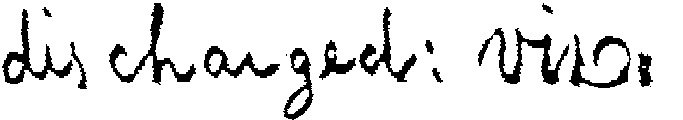

discharged: viz.
torch.Size([3, 384, 384])
torch.Size([200])
{'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), 'labels': tensor([    0,  7779, 18716,    35, 27155,     4,     2,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -10

In [55]:
# Displaying an image and the pixel values and the encoded ground truth text
image = Image.open(train_df_1.location + train_1['file_name'][0]).convert("RGB") # display image
display(image)

enc = train_df_1[0] # getting the first insatnce from the ImageData object of data_1
input_ids = enc['labels'] # retrieving the inputs ids of the text
input_ids[input_ids == -100] = processor.tokenizer.pad_token_id # replace all -100 with the pad token
pred = processor.decode(input_ids, skip_special_tokens=True) # decoding the input_ids to plain text

# printing details
print(pred) # the decoded text
print(train_df_1[0]['pixel_values'].shape) # dimensions of the pixel_values
print(train_df_1[0]['labels'].shape) # dimensions of the labels
print(train_df_1[0]) # displaying the pixel_values and input ids to check out how they look

## Model Training
Training or fine-tuning the model to perform historical charcaters' recognition.

In [56]:
def decode (pred, actual, processor):
  """
  Function to retrive the strings from the encoded input ids.
  Parameters:
  pred - input ids of the predicted strings
  actual - encoded input ids of the original strings
  processor - the processor to use for decoding
  """
  actual[actual == -100] = processor.tokenizer.pad_token_id # all -100 are pad tokens
  # decoding the actual strings
  dec_actual = processor.batch_decode(actual, skip_special_tokens=True)
  # decoding the predicted strings by skipping on the special tokens (like the cls token)
  dec_pred = processor.batch_decode(pred, skip_special_tokens=True)
  return dec_actual, dec_pred


def metrics (pred, actual, processor):
  """
  Function to compute metrics and necessary measures for computing metrics.
  Parameters:
  pred - input ids of the predicted string/word
  actual - encoded input ids of the original string
  processor - the processor to use for decoding
  """
  dec_actual, dec_pred = decode(pred=pred,actual=actual, processor=processor) # decoding the 2 string lists
  matches = 0 # represents the word matches between the actual and predicted strings
  num_words = 0 # represents the number of predicted words
  print(dec_actual, '\n',dec_pred)

  for i in range(len(dec_actual)): # iterating over the list od decoded sentences or image text
    actual1 = dec_actual[i].split() # splitting the decoded original string by spaces to retrieve words in that sentence
    pred1 = dec_pred[i].split() # splitting the decoded prediction by spaces to retrieve words in that sentence
    if len(actual1) > 1: # if the text contains more than 1 word
      for j in range(min(len(actual1), len(pred1))): # iterating over the words in the sentences 
      # but only as many as the ones in the shortest of those sequences
        if pred1[j] == actual1[j]: # the words decoded are compared
          matches += 1
    else: # if the text contains 1 word
      if pred1 == actual1: # the words are compared
        matches += 1
    num_words += len(pred1) # to count the number of words

  cer = cer_metric.compute(predictions=dec_pred, references=dec_actual) # cer metric is calculated for this batch
  return matches, num_words, cer


In [62]:
# Changing to GPU just before training to save it for the intensive computations
# to perform execution on gpu if is avaliable else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device) # to add the model to the device (either a CPU or GPU)
custom_model.to(device) # to add the custom model to the device (either a CPU or GPU)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=76

In [92]:
def training (epochs, model, processor, train_dataloader, val_dataloader):
  """
  Function to perform model training.
  Parameters:
  epochs - number of iterations to run the training function
  model -the TrOCR model to use
  processor - the TrOCR processor to use
  train_dataloader - dataloader with training data
  val_dataloader - dataloader with validation data
  """
  losses = [] # to store the list of losses in each epoch

  # metrics for the entire validation process
  correct_matches = 0 # represents the exact word macthes between the actual and predicted strings
  total_preds = 0 # represents the total number of predicted words
  cer_sum = 0 # represents the sum of cer of all batches

  # Training the model on the training data and validating using the validation for the given number of epochs
  for epoch in range(epochs):
    loss_sum = 0.0 # represents the sum of the loss loss computed after forward propagation of the inputs over each batch
    model.train() # to put in training mode to activate Dropout and BatchNorm layers
    
    # iterating all the batches of data in the DataLoader with training data 
    # with the pixel values and associated ground truth= keys and values of the ImageData objects
    # tqdm is used for displaying the progress bar covering each of the batches
    for batch in tqdm(train_dataloader):
        # data is used on the same device as the model
        for key,value in batch.items(): # iterating over the keys of the batch dictionary
          batch[key] = value.to(device)
    
        optimizer.zero_grad() # resetting the gradients of optimized tensor to 0
        outputs = model(**batch) # the input is passed to the model for forward propagation
        loss = outputs.loss # represents the loss computed after forward propagation of the inputs
        loss.backward() # backward propagation, calculating gradients
        loss_sum += loss.item() # loss is converted into a number and is on the CPU now
        optimizer.step() # optimizer is run, weights are updated
    
    final_loss = loss_sum/len(train_dataloader) # loss over the entire epoch (average of all batches)
    losses.append(final_loss) # adding the loss value to the losses list
    print("Loss after epoch" , epoch , "=" , final_loss)
      
    model.eval() # setting to validation mode where Dropout and BatchNorm layers are deactivated
    with torch.no_grad(): # to not calculate gradients
      for batch in tqdm(val_dataloader): # iterating over the validation set
        pixel_values = batch["pixel_values"].to(device) # pixel values is put on the device
        pred = model.generate(pixel_values, max_new_tokens=200) # the prediction is generated from the image's pixel values
        matches, pred_len, cer = metrics(pred=pred, actual=batch["labels"], processor=processor) # getting the metrics and other measures
        correct_matches += matches # summing the correct exact word matches
        total_preds += pred_len # summing the number of predicted words
        cer_sum += cer

  # PLotting the loss values after training over the epochs
  plt.title("Losses over the Epochs") # plot's title
  plt.xticks(range(0,epochs+1)) # range of the x axis
  plt.plot(losses) # plotting the loss values
  plt.ylabel('loss values') # x axis' label
  plt.xlabel('number of epochs')  # y axis' label
  plt.show() # to display the plot

  # printing the computed metrics
  precision = correct_matches/total_preds # number of correct matches / total number of predicted words
  print("Validation Precision:", precision)
  recall = correct_matches/(len(val_df)*epochs) # number of correct matches / number of words
  f1 = (2*precision*recall)/(precision+recall) # F1 score
  print("Validation Recall:", recall)
  print("Validation F1:", f1/epochs)
  print("Validation CER:", cer_sum/(len(val_dataloader)*epochs))



  0%|          | 0/124 [00:00<?, ?it/s]

Loss after epoch 0 = 0.8543933124822234


  0%|          | 0/42 [00:00<?, ?it/s]

['1911', '28th. To Lieutenant Bacon of the Maryland', '1899', 'the 25th. Instant, must immediately proceed', '1918', '1903', '1911', '1921', '1900', '1908', '1915', '1904', 'Winchester, you must provide your men with Car-', '1901', '1907', 'Musquets; twenty Bayonets, and ten Cartouch-'] 
 ['1911', '28th. To Lieutenant and Baconland', '1899', 'the 1th. To Stewart, and more', '1918', '1905', '1911', '1921', '1900', '1908', '1915', '1904', 'Winchester men has made from your place here-', '1901', '1907', 'Musquets, twenty Boydons, and ten hundred-']
['306. Letters Orders and Instructions. Decem. 1755', '1905', 'rer for the balance of that ten thousand', '1903', '1908', '1900', '1900', '1923', 'Instructions.', '1922', '1912', '1914', '1909', '1900', '1912', '1909'] 
 ['306. Letters Orders Orders Orders and Instructions. 1755.', '1906', 'can for the Subaltern of that time and', '1903', '1906', '1900', '1900', '1923', 'Instruisions.', '1922', '1912', '1914', '1909', '1900', '1912', '1909']
['

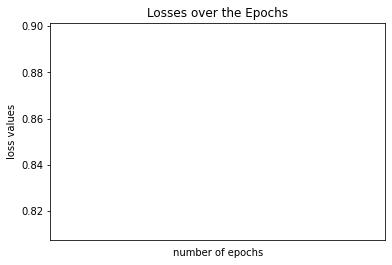

Validation Precision: 0.5618591934381408
Validation Recall: 1.2435703479576399
Validation F1: 0.7740112994350282
Validation CER: 0.2849865851784846


In [64]:
# calling the training function to train the given model with the given processor on the training data given 
# and running validation for the validation data given, all over the specified number of epochs
# training(epochs=1, model=model, processor=processor, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# the below line was used for training the custom-made HuggingFace model directly
training(epochs=1, model=custom_model, processor=processor, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [65]:
# custom_model.save_pretrained(".", push_to_hub=True, repo_id="hist-trocr", private=True) # to save and push the custom trained model trained again to the private huggingface repository with the given id
model.save_pretrained(".", push_to_hub=True, repo_id="hist-trocr", private=True) # to save and push the trained model to the private huggingface repository with the given id

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

## Inference and Testing
Testing and evaluating the fine-tuned model on the test data set.

### Inference on individual images

In [68]:
average_time_taken = 0 # represents average time taken to convert a given image to pixels and generate text from the pixels is
def inference_on_image(image):
  """
  To read an image and generate text in the image
  Parameters:
    image - image in PIL format 
  """
  start = time.time()
  pixel_values = processor(image, return_tensors="pt").pixel_values
  pred = custom_model.generate(pixel_values.to(device), max_new_tokens=100) #model or custom
  dec_pred = processor.batch_decode(pred, skip_special_tokens=True)[0]
  time_taken = time.time() - start
  return dec_pred, time_taken

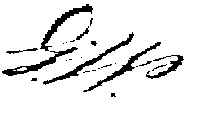

G.


In [69]:
image1 = Image.open(test_df_1.location + test_1['file_name'][0]).convert("RGB")
display(image1)
text, time_taken = inference_on_image(image1)
average_time_taken+= time_taken
print(text)

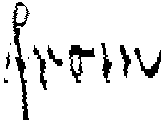

from


In [70]:
image1 = Image.open(test_df_1.location + test_1['file_name'][50]).convert("RGB")
display(image1)
text, time_taken = inference_on_image(image1)
average_time_taken+= time_taken
print(text)

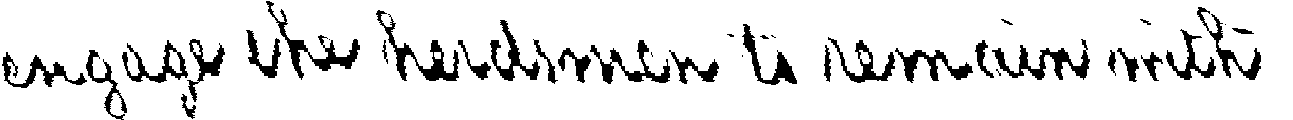

engage the hundred to remain to remain with


In [71]:
image1 = Image.open(test_df_1.location + test_1['file_name'][100]).convert("RGB")
display(image1)
text, time_taken = inference_on_image(image1)
average_time_taken+= time_taken
print(text)

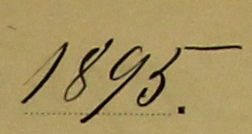

1895


In [72]:
image1 = Image.open(test_df_2.location + test_2['file_name'][11]).convert("RGB")
display(image1)
text, time_taken = inference_on_image(image1)
average_time_taken+= time_taken
print(text)

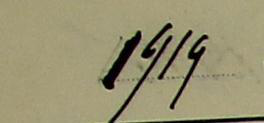

1919


In [73]:
image1 = Image.open(test_df_2.location + test_2['file_name'][75]).convert("RGB")
display(image1)
text, time_taken = inference_on_image(image1)
average_time_taken+= time_taken
print(text)

In [74]:
print("The average time taken to read text from an image is", average_time_taken/5, "seconds")

The average time taken to read text from an image is 0.1505420684814453 seconds


### Model Testing

In [75]:
def testing (model, processor, test_dataloader):
  """
  Function to test the model on the given data
  Parameters:
  epochs - number of iterations to run the training function
  model -the TrOCR model to use
  processor - the TrOCR processor to use
  test_dataloader - dataloader with testing data
  """
  correct_matches = 0 # represents the exact word macthes between the actual and predicted strings
  total_preds = 0 # represents the total number of predicted words
  cer_sum = 0 # represents the sum of cer of all batches

  # iterating all the batches of data in the DataLoader with testing data 
  # with the pixel values and associated ground truth- keys and values of the WordData objects
  # tqdm is used for displaying the progress bar, covers each of the batches
  for batch in tqdm(test_dataloader):
      # putting the values in the batch on the same device as the model
      pixel_values = batch["pixel_values"].to(device)
      text = batch["labels"].to(device)
      pred = model.generate(pixel_values, max_new_tokens=100) # getting the prediction for the given image's pixels
      matches, pred_len, cer = metrics(pred=pred, actual=text, processor=processor) # getting the metrics and other measures
      correct_matches += matches # summing the correct exact word matches
      total_preds += pred_len # summing the number of predicted words
      cer_sum += cer # cer metric is summed for this batch

  # printing the values of the metrics on the test data
  print("On test set:")
  precision = correct_matches/total_preds
  print("Precision:", precision)
  recall = correct_matches/len(test_df)
  print("Recall:", recall)
  print("F1:", (2*precision*recall)/(precision+recall)) # F1 Score
  print("CER:", cer_sum/len(test_dataloader)) # represents the cer acccumulated over the batches

In [76]:
# testing(model=model, processor=processor, test_dataloader=test_dataloader) # calling the testing function to test the given model with processor on the given test data
testing(model= custom_model, processor=processor, test_dataloader=test_dataloader) # used at later stages of testing when the already trained model pushed to Huggingface was directly imported

  0%|          | 0/42 [00:00<?, ?it/s]

['1905', 'seeing these things done, until further Orders.', '1912', '1903', '1896', 'G.W. Aid de camp.', 'tences, until your Honour shall be made ac-', '1899', '1914', '1906', 'then only to forward it up.', '1902', '1921', 'are to be made to the Aid de Camp.', '1913', '1902'] 
 ['1906', 'serving, These things, and Instructions.', '1912', '1903', '1896', 'G.', 'two, until your Honour shall be made de-', '1899', '1914', '1906', 'then only only to General it you.', '1902', '1921', 'a to be made to the time de camp-', '1913', '1902']
['1903', '1931', '1907', '1905', '1900', '1908', '1908', '1904', '1901', '1920', '1898', '1906', '1904', '1896', 'me.', '11th. 1755.'] 
 ['1903', '1931', '1907', '1905', '1900', '1906', '1908', '1904', '1901', '1920', '1898', '1906', '1904', '1896', 'me.', '1555. 1755.']
['1912', 'missary or from me. You must engage', '1927', 'Parole', 'the', 'G.W.', '1898', '1908', '1899', '1899', '1919', '1914', 'You', '1917', '1906', 'December 16th. 1755.'] 
 ['1912', 'miss

## Gradio Demo Creation 
The code used to create a Gradio model.
This code in used in app.py file in HuggingFace repo to deploy the model as a Space.

In [ ]:
title = "Hist-TrOCR" # title of the space
# description to be displayed to the users below the title
description = "Interactive demo of Hist-TrOCR, a fine-tuned version of Microsoft's TrOCR which is an end-to-end transformer model used for recognition of text from single-line or word images. It has been fine-tuned on historical text images. Upload an image or use one of the sample images below and click 'submit' to get the transcriptions. Results may take a few seconds to show up."

# creating a Gradio interface with the pixel reading and text reading function, expected input and output type, title, description
# it is also launched to create a link that is shareable (so not local).
# This is just a demo of creating the Space, the code to deploy the space on HuggingFace does not have an explicit share option
gr.Interface(fn=inference_on_image, 
                     inputs=gr.inputs.Image(type="pil"), 
                     outputs=gr.outputs.Textbox(),
                     title=title,
                     description=description).launch(debug=True, share=True)

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://31369ba3-fe72-4ba5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 32 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 32 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://31369ba3-fe72-4ba5.gradio.live


## Model and Data Experimentation

### Testing the model on images from the IAM Handwriting Database

In [77]:
# reading the text file associated with the images' names and ground truth from the IAM Handwriting Database
data_iam = pd.read_fwf('/content/drive/MyDrive/Colab Notebooks/IAM/gt_test.txt', header=None)
images_location_3 = '/content/drive/MyDrive/Colab Notebooks/IAM/image/' # path of images associated with this dataset
data_iam.head() # having a look at samples in the dataframe

,0,1,2
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...,NaN
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone...",.
2,c04-110-02.jpg,I don't think he will storm the charts with th...,NaN
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-...",NaN
4,c04-116-00.jpg,He is also a director of a couple of garages ....,NaN


In [78]:
print("Dimensions of the dataframe: ",data_iam.shape) # shape of the dataframe; given as (rows,columns)

Dimensions of the dataframe:  (2915, 3)


In [79]:
data_iam.drop([2], axis = 1, inplace = True) # dropping the column named '2' as it only contains NaNs and also is not required
data_iam.rename(columns={0: "file_name", 1: "text"}, inplace=True) # renaming the columns for better readbility
print(data_iam[data_iam['file_name'].str.endswith('jpg')].shape) # to ensure all file names end with jpg

(2695, 2)


In [80]:
# most file names end with jpg but some end with jp and such ones are modified to be jpg
data_iam['file_name'] = data_iam['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
# getting a random sample of 661 images so that this size matches with that of the 
# test data size from the Washington Database and ARDIS Dataset
data_iam = data_iam.sample(661)
data_iam.reset_index(drop=True, inplace=True) # resetting the indices of the dataset after the sample is chosen
data_iam.head() # glimpse of the dataframe after all the modifications

,file_name,text
0,n01-020-07.jpg,radar glowed . Occasionally minute spots
1,m01-049-08.jpg,his toes . He stretched his arms
2,g01-070-04.jpg,most notorious third poll-tax was agreed
3,n06-140-07.jpg,was never long on patience .
4,d04-021-00.jpg,The action of the Shamir writes books and their


In [81]:
print("Dimensions of the dataframe: ",data_iam.shape) # shape of the dataframe; given as (rows,columns)

Dimensions of the dataframe:  (661, 2)


In [82]:
data_iam.isnull().sum() # confirming the dataframe does not contain any NULL values

file_name    0
text         0
dtype: int64

In [83]:
data_iam[data_iam['text'] == ''].index # confirming the dataframe does not contain any empty values

Int64Index([], dtype='int64')

In [84]:
# to check for duplicate entries
data_iam[data_iam.duplicated()] # or set(data.duplicated()) gives only False

,file_name,text


In [85]:
# Creating ImageDataset objects for training, validation and testing sets
test_df_iam = ImageData(data=data_iam, location=images_location_3, processor=processor)
# Creating DataLoader, each element is a batch of size 32* with data samples and all batches are shuffled at every epoch 
test_dataloader_iam = DataLoader(test_df_iam, batch_size=16, shuffle=True)

In [87]:
# calling the testing function to test the given model with processor on the given test data from the IAM Handwriting Databse
testing(model=custom_model, processor=processor, test_dataloader=test_dataloader_iam)

  0%|          | 0/42 [00:00<?, ?it/s]

['Name and the Gemara here quotes the', 'length subside, He throws a bed of glowing', 'ne through the mill, we need not teach them', 'involving careful and patient treatment.', 'work. The only connexion is the', 'day week so that in the first week', 'at the Villa in time.', 'Anyhow, Homer does not seem to have', 'knew perfectly well that Byron, as early', 'glance at him. Evidently the other occupant', 'and have been over to sit with her father and do what', 'it added immensely to the interest', 'was prepared to accept the responsibility.', 'you the best way I can by getting hold of Jack', 'was a subject of no little importance to the Romans.', 'But not for long, for soon pedestrians and cars flocked upon'] 
 ['You are at etc.', 'High service, etc. and of the place of giving', 'me Haggs. He had to see hundred for that time', 'driving carry among case, and patient.', 'used. He are to arrive on the arrival on the', 'day made to the first arrival.', 'the Billa Billa.', 'Arms, Hence, etc.',

### Training with just one of the datasets

In [88]:
# custom_model.save_pretrained(".", push_to_hub=True, repo_id="hist-trocr", private=True) # to save and push the custom trained model trained again to the private huggingface repository with the given id
model.save_pretrained(".", push_to_hub=True, repo_id="hist-trocr", private=True) # to save and push the trained model to the private huggingface repository with the given id

In [96]:
# configuring the base_handwritten model and setting undefined parameters, used initially before the custom_model was made
# the decoder input_ids require the start and pad tokens, they are created by shifting the input to the right once
def initialize_model():
  model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
  model.config.decoder_start_token_id = processor.tokenizer.cls_token_id # id (=0) of the class token- <s> used as the first token after the inputs are shifted to the right for the decoder
  model.config.pad_token_id = processor.tokenizer.pad_token_id # id (=1) of the pad token- <pad>
  model.config.vocab_size = model.config.decoder.vocab_size # language modelling vocabulary size is set to default value of the decoder of the model (=50625)

  # sequence generation parameters associated with beam search (https://huggingface.co/blog/how-to-generate)
  model.config.eos_token_id = processor.tokenizer.sep_token_id # id (=2) of the separator token- </s> that is used at the end of the string, originally undefined
  model.config.max_length = 200 # maximum length to be used by the text generation function, originally 20
  # for below value- (https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/#:~:text=Common%20beam%20width%20values%20are,better%20matching%20a%20target%20sequence.)
  model.config.num_beams = 5 # number of beams in beam search, beam width - number of sequences to consider while picking the one with the highest probablity, originally 1 (so only greedy search)
  model.config.early_stopping = True # beam search is stopped when 5(num_beams) sentences are done at a time (batch), originally False
  model.config.no_repeat_ngram_size = 3 # ngrams of size 3 can occur only once, to avoid word repetitions
  return model

  0%|          | 0/29 [00:00<?, ?it/s]

Loss after epoch 0 = 4.06297177281873


  0%|          | 0/10 [00:00<?, ?it/s]

['give such directions as you shall see necessary about', 'nition, you are to supply him from the', '5th. To John Robinson Esquire, Speaker.', 'ons about the Provisions; I should be glad to', 'Captain', 'G.W.', 'morthy, since you have honoured me with', 'Winchester:', 'they arrive at Fort Cumberland) the Company', 'gence in pursuing and apprehending them, by im-', 'livered out, but by a written order from him or', 'would fix it: so is Captain Stewarts: If Captain Stew-', '306. Letters Orders and Instructions. Decem. 1755', 'Cumberland, with Clothing and Arms, to see', 'Musquets; twenty Bayonets, and ten Cartouch-', 'The Officers are to see that the men are clo-'] 
 ['piece such directions are you shall see more money about', 'million; you are to supply him from the', '17th. John Dickinson Recruits,', 'oms about the Provisions, I should be', 'also captain', 'Gett.', 'meat, since you have honoured me with', 'Winchester:', 'chery arrive at Fort Fort Cumberland, that Company', 'gence in pu

  0%|          | 0/29 [00:00<?, ?it/s]

Loss after epoch 1 = 0.839520748319297


  0%|          | 0/10 [00:00<?, ?it/s]

['from Fort Cumberland and this place', 'Winchester, you must provide your men with Car-', 'a, the 1st of December.', 'with eight good men: as that Company is', 'and repairing the Drums. - These deductions you are', 'Fort Cumberland this Winter; I am sensible,', 'ficient number of waggons to carry them to Win-', 'Alexandria: December 3, 1755.', '272. Letters, Orders and Instructions. October', 'Regiment.', 'and the horses given to him. You must', 'ply, if he had any such thoughts. I believe, on', 'one hundred pounds to recruit with; and', 'p.309.', 'desire the Treasurer to send some part of the', '16th. To Doctor James Craik, of the Virginia'] 
 ['from Fort Cumberland and this place', 'Winchester, you must provide your men with a-', 'a, etc 5th. December.', 'with eight good men, and that Company is', 'microsopacing the Drums. - - - The ex destruction, you are', 'Fort Cumberland this Winter; I am sensible,', 'ficient number of waggons to carry them to Mr-', 'Alexandria: December 3th. 17

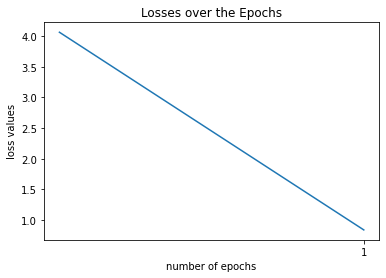

Validation Precision: 0.5816959669079628
Validation Recall: 0.850983358547655
Validation F1: 0.3455159705159705
Validation CER: 0.1708175925163429


In [89]:
# calling the training function to train the given model with the given processor on the training data from data_1 
# and running validation on the validation data from data_1 , all over the specified number of epochs
model = initialize_model()
model.to(device)
training(epochs=2, model=model, processor=processor, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader_1)

In [90]:
# calling the testing function to test the given model with processor on the given test data from data_1
testing(model=model, processor=processor, test_dataloader=test_dataloader_1)

  0%|          | 0/10 [00:00<?, ?it/s]

['from', '16th. To Ensign Buckner. Quarter Master to the Virginia', 'G.W.', 'tion made between them and Sergeants,', 'Winchester, October G.W.', 'I received yours of the 6th. of Octo-', '8th. To Captain Robert Stewart,', 'Alexandria: December 16, 1755.', 'ses; and that you would be kind enough to', 'know, whether you would have more laid in', 'seeing these things done, until further Orders.', 'Suits than are necessary, in case of getting', 'until further orders- Lieutenant Eustace, and', 'with the utmost dispatch to Fort Cumberland,', 'see that money is lodged with Mr. Dick', 'three men on his march, and I have or-'] 
 ['from', '70th. To Ensign. December 17th. Virginia', 'Gigs', 'tion made between them and Sergeant,', 'Winchester October 20th. 17th.', 'I received Yours of the C.W. etc.', '1st. To Captain Robert Stewart,', 'Alexandria: December 16th, 1755.', 'ses, and that you would be kind enough to', 'know, whether you would have more laid in', 'seeing these them of Love, until furthe

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 0 = 10.097756127516428


  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


['1915', '1915', '1903', '1905', '1897', '1933', '1895', '1921', '1922', '1909', '1905', '1903', '1924', '1912', '1900', '1918'] 
 ['2 1/695', '2 1915', '1903', '0 1905-', '2 1897', '2b.QB', '- 1895', '1921', '1922.', 'play by', '2 1905.', 'spots.', '2924', '- 1918.', '1 900', '1918']
['1903', '1906', '1897', '1912', '1906', '1930', '1905', '1910', '1904', '1896', '1902', '1914', '1924', '1898', '1905', '1903'] 
 ['8 1903.', '2 1906.', '- 1897.', '1972.', '2 1glots.', '0 1920.', '1983.', '1910', 'supports.', '2 1891s', '. 1902.', 'might', '0 1924', '2, 1898', '1905', '2 1903.']
['1905', '1903', '1904', '1902', '1908', '1915', '1911', '1910', '1907', '1903', '1949', '1895', '1906', '1899', '1916', '1902'] 
 ['2 LOOK.', '1903', '1 1904.', '1 190.4', '1908', '2 laps.', '1.1.', '2 1glide.', '1907', '- 1903.', '0 1979', '2 1895', '2 190 lb.', '1899', '2 19th.', '- 1902.']
['1909', '1924', '1918', '1913', '1918', '1909', '1901', '1924', '1911', '1914', '1900', '1921', '1902', '1911', '1920',

  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 1 = 10.096349368492762


  0%|          | 0/32 [00:00<?, ?it/s]

['1896', '1897', '1905', '1901', '1911', '1941', '1896', '1912', '1916', '1918', '1924', '1929', '1912', '1903', '1904', '1900'] 
 ['2 1806s.', '1897', '1405', '1981', '0 1911.', '2 194.', '1896', '1 912.', '2 Kyle.', '2 1918', '1924.', '0 1929', '1972.', '" 1200', '2 1904.', '1900']
['1901', '1922', '1931', '1944', '1916', '1921', '1912', '1904', '1896', '1910', '1902', '1908', '1905', '1897', '1897', '1918'] 
 ['2 1901.', '3 1982', '0 1931', '- 1944.', '2 1/416.', '2 1g2I.', '6 1/ 9.1.2', '- 1904.', '2 28gls.', '1910', '1902', 'expense.', '1905.', '- 189th.', '2 1897', '1918']
['1916', '1905', '1914', '1958', '1918', '1910', '1899', '1905', '1905', '1909', '1907', '1903', '1920', '1912', '1904', '1900'] 
 ['2 1916.', '0 1903.', '2 1914.', '1958', '1918', '2 1yo', '0 1899.', '1905', '2 LOOK.', '1gog', '0 1907', '1903', '0 1/2 )', '8 Aql2', '0 1904.', '1 900']
['1920', '1901', '1908', '1895', '1915', '1909', '1906', '1907', '1903', '1914', '1931', '1903', '1910', '1895', '1913', '1923'

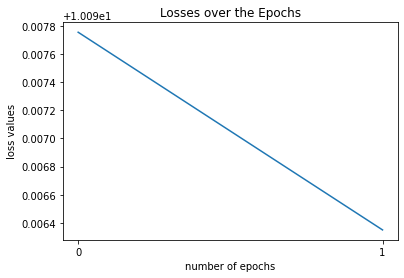

Validation Precision: 0.12338425381903642
Validation Recall: 0.1588502269288956
Validation F1: 0.06944444444444445
Validation CER: 0.7026018415178572


In [97]:
# calling the training function to train the given model with the given processor on the training data from data_2
# and running validation on the validation data from data_2, all over the specified number of epochs
model = initialize_model()
model.to(device)
training(epochs=2, model=model, processor=processor, train_dataloader=train_dataloader_2, val_dataloader=val_dataloader_2)

In [98]:
# calling the testing function to test the given model with processor on the given test data from data_2
testing(model=model, processor=processor, test_dataloader=test_dataloader_2)

  0%|          | 0/32 [00:00<?, ?it/s]

['1908', '1901', '1902', '1897', '1899', '1897', '1907', '1904', '1917', '1955', '1905', '1900', '1913', '1909', '1915', '1899'] 
 ['2 1908.', '1990s', '1 1glo.', '1897', '. 1899', '2 1896.', '0 1907', 'supply', '2 1 GIF', '0 1951.', '2 1905', '1 1,', '0 1913.', '1909', '6 1 1/plus.', '1899']
['1929', '1935', '1903', '1903', '1908', '1919', '1898', '1902', '1902', '1896', '1935', '1896', '1908', '1918', '1918', '1903'] 
 ['1929', '1935', '2 1903.', '1903', '2 1908.', '1 1/', '0 1-', '1908', '1902', '2 1angle.', '0 1935', '- 1896.', '2 1908', '1918', '2 1918.', '2 1903.']
['1903', '1906', '1898', '1923', '1905', '1934', '1898', '1936', '1905', '1909', '1902', '1900', '1915', '1907', '1907', '1903'] 
 ['" 1907.', '2 190.', '. 1898', '- 1923.', '2 1905', '2 1934.', '0 1898.', '0 1936', '2 1905', '2 1960s', '2 190.', '1970s', '0 1915.', '1907.', '2 1987', '8 1903.']
['1933', '1919', '1904', '1898', '1912', '1898', '1911', '1901', '1896', '1917', '1906', '1905', '1901', '1904', '1895', '190

### TrOCR handwritten: base v/s small v/s large

In [ ]:
# calling the training function to train the given model with the given processor on the training data from data_1 
# and running validation on the validation data from data_1 , all over the specified number of epochs
model = initialize_model()
model.to(device)
training(epochs=2, model=model, processor=processor, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [ ]:
# calling the testing function to test the given model with processor on the given test data
testing(model=model, processor=processor, test_dataloader=test_dataloader)

#### Using trocr-small-handwritten

In [99]:
# required for the decoder; not installing gives "You need to have sentencepiece installed to convert a slow tokenizer to a fast one" error
!pip install sentencepiece
# using the trocr_small_handwritten model and processor
processor1 = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
model1 = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.4 MB/s eta 0:00:00


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
# configuring the model and setting undefined parameters
# the decoder input_ids require the start and pad tokens, they are created by shifting the input to the right once (same as the original model's configuration)
model1.config.decoder_start_token_id = processor.tokenizer.cls_token_id # id (=0) of the class token- <s> used as the first token after the inputs are shifted to the right for the decoder
model1.config.pad_token_id = processor.tokenizer.pad_token_id # id (=1) of the pad token- <pad>
model1.config.vocab_size = model.config.decoder.vocab_size # language modelling vocabulary size is set to default value of the decoder of the model (=50625)

# sequence generation parameters associated with beam search (https://huggingface.co/blog/how-to-generate)
model1.config.eos_token_id = processor.tokenizer.sep_token_id # id (=2) of the separator token- </s> that is used at the end of the string, originally undefined
model1.config.max_length = 100 # maximum length to be used by the text generation function, originally 20
# for below value- (https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/#:~:text=Common%20beam%20width%20values%20are,better%20matching%20a%20target%20sequence.)
model1.config.num_beams = 5 # number of beams in beam search, beam width - number of sequences to consider while picking the one with the highest probablity, originally 1 (so only greedy search)
model1.config.early_stopping = True # beam search is stopped when 5(num_beams) sentences are done at a time (batch), originally False
model1.config.no_repeat_ngram_size = 3 # ngrams of size 3 can occur only once, to avoid word repetitions

In [101]:
# displaying the processor's details to compare with the ones of the original (trocr_base_handwritten) model
print(processor1.image_processor)
print(processor1.image_processor.model_input_names)
print(processor1.tokenizer)
print(processor1.tokenizer.model_input_names)

DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

['pixel_values']
XLMRobertaTokenizerFast(name_or_path='microsoft/trocr-small-handwritten', vocab_size=64002, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})
['input_ids', 'attention_mask']


In [102]:
# Creating ImageDataset objects for training, validation and testing sets (similar to what was done in the Dataset Preparation Section earlier)

# ImageData objects for the split dataframes of data_1 with the trocr_small_handwritten processor
train_df_1 = ImageData(data=train_1, location=images_location_1, processor=processor1)
val_df_1 = ImageData(data=val_1, location=images_location_1, processor=processor1)
test_df_1 = ImageData(data=test_1, location=images_location_1, processor=processor1)
# ImageData objects for the split dataframes of data_2
train_df_2 = ImageData(data=train_2, location=images_location_2, processor=processor1)
val_df_2 = ImageData(data=val_2, location=images_location_2, processor=processor1)
test_df_2 = ImageData(data=test_2, location=images_location_2, processor=processor1)
# Concatenated ImageData objects for the training, validation, and test sets
train_df = ConcatDataset([train_df_1,train_df_2])
val_df = ConcatDataset([val_df_1,val_df_2])
test_df = ConcatDataset([test_df_1, test_df_2])

# Creating DataLoaders for training, validation and testing data sets, each element is a batch of size 32*
# with data samples and all batches are shuffled at every epoch 
train_dataloader = DataLoader(train_df, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_df, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_df, batch_size=16, shuffle=True)

  0%|          | 0/124 [00:00<?, ?it/s]

Loss after epoch 0 = 12.495307683944702


  0%|          | 0/42 [00:00<?, ?it/s]

['1900', '1902', '1902', '1908', '1896', '1904', '1910', '1904', '1933', '1905', 'at', 'Flints', '1903', 'ons about the Provisions; I should be glad to', '1901', '1906'] 
 ['.', 'In the Philadelphia Philadelphia Philadelphia Presidential Presidential Presidential Philadelphia Presidential Non Presidential Presidential Disabilities Presidential Presidential Inter Presidential Presidential Constitutional Presidential Presidential Intellectual Presidential Presidential Immaculate Presidential Presidential " Non Presidential Intellectual Disabilities Presidential Disabilities " Presidential Presidential Household Presidential Presidential Journalists Presidential Presidential I Presidential Presidential In Presidential Presidential\' Presidential Presidential Non  In Presidential Immaculate Immaculate Presidential Intellectual Immaculate Presidential Immaculate Disabilities Presidential Immaculate Household Presidential Immaculate Inter Presidential Disabilities\' Immaculate Presidential "

  0%|          | 0/124 [00:00<?, ?it/s]

Loss after epoch 1 = 12.493412048585954


  0%|          | 0/42 [00:00<?, ?it/s]

['1913', 'chants, whether Commissary Walker has en-', 'Cumberland, with Clothing and Arms, to see', 'the Companies at Fort Cumberland, you are', '1897', '1903', 'burgh, informing me that peace prevailed', '1912', '1899', '1896', '1899', 'for packing the Beef; and if any of the', '1916', '1899', '1895', '1901'] 
 [". What happened. The President's.", 'non non non- transgression non- transgress " non inappropriate non non inappropriate " for non non  non non " non- In non " for " non " I non- non- transferring " for inappropriate " borrowing " for pro non " No inappropriate " No non inappropriate I non inappropriate\'for non inappropriate shortcomings " borrowing I non  In non inappropriate for non " In non non pro non inappropriate No non non no non non microorganisms " for microorganisms I non non r " for its " borrowing for non  forgiveness " borrowing non  for inappropriate I\'for inappropriate for inappropriate non inappropriate borrowing " No  for non microorganisms I\'non non part

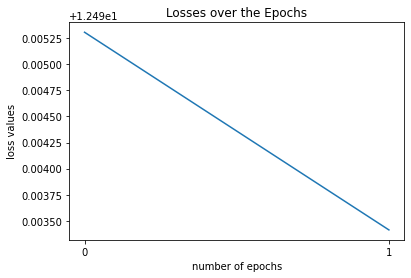

Validation Precision: 0.0006420958006934634
Validation Recall: 0.015128593040847202
Validation F1: 0.0006159531875577456
Validation CER: 15.027839514590365


In [103]:
# calling the training function to train the given model with the given processor on the training data given 
# and running validation for the validation data given, all over the specified number of epochs
model1.to(device)
training(epochs=2, model=model1, processor=processor1, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [104]:
# calling the testing function to test the given model with processor on the given test data
testing(model=model1, processor=processor1, test_dataloader=test_dataloader)

  0%|          | 0/42 [00:00<?, ?it/s]

['Winchester, October G.W.', '1908', 'from the Regiments into which they were draugh-', '1898', '1902', '1901', '1898', 'amsburgh, I intended to proceed to Winches-', '1915', 'the Clothes and Arms arrive, to furnish all the', '1919', '1913', '1921', 'the', '1900', 'ter. You are to provide yourself here, with'] 
 ['in Columbus. October October Columbus October October October 0 October 0 0 0 6 0 0 10 0 0 1', '" What happened " " What "\'"\'\' What happened\'\'\'" What\'" "\'What\'\'.\'\' President\'\' I\'\'', 'in most respects most most most respects -', '.', '5000 000 000500 000 000 000 500 000 000 THROUGH.', '. What.....', '. What! What (', '" Inter-', "in the competitive participation of the prestigious participation's", 'running current run runners our curious curious running curious curious curious current curious current current curious curious Jimmy curious curious currently curious curious Burns current curious Burns curious current Jimmy curious current Burns current current cu

#### Using trocr-large-handwritten

In [105]:
# using the trocr_large_handwritten model and processor
processor2 = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model2 = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
# configuring the model and setting undefined parameters
# the decoder input_ids require the start and pad tokens, they are created by shifting the input to the right once (same as the original model's configuration)
model2.config.decoder_start_token_id = processor.tokenizer.cls_token_id # id (=0) of the class token- <s> used as the first token after the inputs are shifted to the right for the decoder
model2.config.pad_token_id = processor.tokenizer.pad_token_id # id (=1) of the pad token- <pad>
model2.config.vocab_size = model.config.decoder.vocab_size # language modelling vocabulary size is set to default value of the decoder of the model (=50625)

# sequence generation parameters associated with beam search (https://huggingface.co/blog/how-to-generate)
model2.config.eos_token_id = processor.tokenizer.sep_token_id # id (=2) of the separator token- </s> that is used at the end of the string, originally undefined
model2.config.max_length = 100 # maximum length to be used by the text generation function, originally 20
# for below value- (https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/#:~:text=Common%20beam%20width%20values%20are,better%20matching%20a%20target%20sequence.)
model2.config.num_beams = 5 # number of beams in beam search, beam width - number of sequences to consider while picking the one with the highest probablity, originally 1 (so only greedy search)
model2.config.early_stopping = True # beam search is stopped when 5(num_beams) sentences are done at a time (batch), originally False
model2.config.no_repeat_ngram_size = 3 # ngrams of size 3 can occur only once, to avoid word repetitions

In [107]:
# displaying the processor's details to compare with the ones of the original (trocr_base_handwritten) model
print(processor2.image_processor)
print(processor2.image_processor.model_input_names)
print(processor2.tokenizer)
print(processor2.tokenizer.model_input_names)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

['pixel_values']
RobertaTokenizerFast(name_or_path='microsoft/trocr-large-handwritten', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, si

In [108]:
# Creating ImageDataset objects for training, validation and testing sets (similar to what was done in the Dataset Preparation Section earlier)
# ImageData objects for the split dataframes of data_1 with the trocr_large_handwritten processor
train_df_1 = ImageData(data=train_1, location=images_location_1, processor=processor2)
val_df_1 = ImageData(data=val_1, location=images_location_1, processor=processor2)
test_df_1 = ImageData(data=test_1, location=images_location_1, processor=processor2)
# ImageData objects for the split dataframes of data_2
train_df_2 = ImageData(data=train_2, location=images_location_2, processor=processor2)
val_df_2 = ImageData(data=val_2, location=images_location_2, processor=processor2)
test_df_2 = ImageData(data=test_2, location=images_location_2, processor=processor2)
# Concatenated ImageData objects for the training, validation, and test sets
train_df = ConcatDataset([train_df_1,train_df_2])
val_df = ConcatDataset([val_df_1,val_df_2])
test_df = ConcatDataset([test_df_1, test_df_2])

# Creating DataLoaders for training, validation and testing data sets, each element is a batch of size 32
# with data samples and all batches are shuffled at every epoch 
train_dataloader = DataLoader(train_df, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_df, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_df, batch_size=16, shuffle=True)

In [110]:
torch.cuda.empty_cache()

In [111]:
# calling the training function to train the given model with the given processor on the training data given 
# and running validation for the validation data given, all over the specified number of epochs
model2.to(device)
training(epochs=2, model=model2, processor=processor2, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

  0%|          | 0/124 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
# calling the testing function to test the given model with processor on the given test data
testing(model=model2, processor=processor2, test_dataloader=test_dataloader)